# Peter De Jong attractors

## Import required packages

In [1]:
using ImageView, TestImages, Images, Colors, FileIO, PerceptualColourMaps

## Define functions to calculate the attractors and make the images

In [2]:
# function to calculate the next point starting from the point X
function calc_next(X::Array{Float64}, params::Array{Float64})
    return [sin(params[1]*X[2])-cos(params[2]*X[1]), sin(params[3]*X[1])-cos(params[4]*X[2])]
end


"""
function for converting n to a greyscale value, default colormap for
attractors
"""
function map_gray(n, alpha)
    return UInt8(floor(UInt8, (clamp(n^alpha * typemax(UInt8)^(1-alpha), typemin(UInt8), typemax(UInt8)))))
end


function linear_color(n, n_max, alpha, rgb)
    color = rgb * n^alpha/n_max^alpha
    return RGB(color[1], color[2], color[3])
end


function linear_color_white(n, n_max, alpha, rgb)
    if n == 0
        color = [1., 1., 1.]
    else
        color = rgb * n^alpha/n_max^alpha
    end
    return RGB(color[1], color[2], color[3])
end
    
    
function color_map_background(n, n_max, alpha, rgb, base)
    color = [red(rgb), green(rgb), blue(rgb)]
    if n == 0
        color = base*color
    else
        color = (n/n_max)^alpha*color
    end
    return RGB(color[1], color[2], color[3])
end

color_map_background (generic function with 1 method)

In [3]:
function calc_attractor(X, params, SIZE, MAX)
    maxi = 0
    # initialize the grid
    grid = zeros(SIZE, SIZE)

    # calculate the points
    while maxi <= MAX
        # calculate the next point
        X = calc_next(X, params)
        # add 1 to the cell in the grid containing this point
        x = floor(Int64, div(SIZE * (X[1]+2), 4)) + 1
        y = floor(Int64, div(SIZE * (X[2]+2), 4)) + 1
        grid[x,y] += 1
        if grid[x,y] > maxi
            maxi = grid[x,y]
        end
    end
    return grid
end


function calc_skewed_attractor(X, params, width, height, MAX)
    maxi = 0
    # initialize the grid
    grid = zeros(height, width)
    SIZE = min(width, height)

    # calculate the points
    while maxi <= MAX
        # calculate the next point
        X = calc_next(X, params)
        # add 1 to the cell in the grid containing this point
        x = floor(Int64, div(SIZE * (X[1]+2), 4)) + 1
        y = floor(Int64, div(SIZE * (X[2]+2), 4)) + 1
        grid[x,y] += 1
        if grid[x,y] > maxi
            maxi = grid[x,y]
        end
    end
    return grid
end

"""
Calculates the attactor on a grid of width width and heigth heigth, it uses an offset of
d_width and d_heigth from the edge of the square in wich the attractor is callculated
"""
function calc_extended_attractor(X, params, width, height, d_width, d_height, MAX)
    maxi = 0
    # initialize the grid
    grid = zeros(height, width)
    SIZE = min(width-d_width*2, height-d_height*2)

    # calculate the points
    while maxi <= MAX
        # calculate the next point
        X = calc_next(X, params)
        # add 1 to the cell in the grid containing this point
        x = floor(Int64, div(SIZE * (X[1]+2), 4)) + 1 + d_width
        y = floor(Int64, div(SIZE * (X[2]+2), 4)) + 1 + d_height
        grid[x,y] += 1
        if grid[x,y] > maxi
            maxi = grid[x,y]
        end
    end
    return grid
end


function calc_stretched_attractor(X, params, width, height, d_width, d_height, MAX)
    maxi = 0
    # initialize the grid
    grid = zeros(height, width)
    size_x = width - 2*d_width
    size_y = height - 2*d_height

    # calculate the points
    while maxi <= MAX
        # calculate the next point
        X = calc_next(X, params)
        # add 1 to the cell in the grid containing this point
        x = floor(Int64, div(size_y * (X[1]+2), 4)) + 1 + d_height
        y = floor(Int64, div(size_x * (X[2]+2), 4)) + 1 + d_width
        grid[x,y] += 1
        if grid[x,y] > maxi
            maxi = grid[x,y]
        end
    end
    return grid
end

calc_stretched_attractor (generic function with 1 method)

In [4]:
"""
Searches for an interestin set of parameters for the attractor
"""
function search_params(len, side)
    pixels = side^2
    X = [1., 1.]
    maxi = 100
    
    # arrays to hold interesting parameter sets
    grids = []
    params = []
    found = 0
    
    while found < len
        # take a random set of parameters
        param = rand(UInt16, 4)/6000
        # calculate the grid
        grid = calc_attractor(X, param, side, maxi)
        # calculate how many pixels are above 5% and above 50%
        amount1 = size(grid[grid .> 5])[1]
        amount2 = size(grid[grid .> 50])[1]
        
        if (amount1 < 0.1*pixels) & (amount2 > 0.0001*pixels)
            print("found: $(found+1). ")
            push!(params, param)
            push!(grids, grid)
            found += 1
        end
    end
    return params, grids
end

search_params

## Make a composite image of candidate attractors

No need to run this again after saving the params

In [ ]:
side = 500
params, grids = search_params(400, side);

In [ ]:
# stitch all the different grids together into 1 composite grid
row = grids[1]

for i = 2:20
    row = hcat(row, grids[i])
end

composite = row

for i = 1:19
    row = grids[20*i+1]
    for j = (20*i+2):(20*(i+1))
        row = hcat(row, grids[j])
    end
    composite = vcat(composite, row)
end

In [ ]:
str = ""
for i = 1:400
    param = params[i]
    str *= "$i: ["
    for a in param
        str *= " $a "
    end
    str *= "]\n"
end
print(str)

In [ ]:
# make a grayscale image from the composite grid and save it
GAMMA = fill(0.25, side*20, side*20)
image = map(map_gray, composite, GAMMA)
save("composite attractors.png", image)

## Make High-res plot of interesting attractors

**Unilumounus color scale to use as background color**

In [9]:
scale = cmap("I3", N=500);
scale = RGB.(scale)

**uniform colors to use as background**

In [ ]:
# vermillion scale (#f4320c)
vermillion = [244,50,12]/244

### Calculate the histogram for the attractor

In [ ]:
# sidelength in pixels of image
SIDE = 3000
# the max value for a pixel and the max value reached
MAX = 6000

X0 = [1., 1.]
param = [ 7.3305  0.8646666666666667  0.37083333333333335  6.1305 ]
#param = rand(UInt16, 4)/6000
grid = calc_attractor(X0, param, SIDE, MAX);

Make a RGB-background for the non-uniform color plots

### Plot the attractor

Uniform color plot

In [ ]:
# the color to use
COLOR = vermillion
# initialize other grids for the map
GAMMA = fill(0.15, SIDE, SIDE)
rgb = fill(vermillion, SIDE, SIDE)
N_MAX = fill(MAX, SIDE, SIDE)
# make the plots, both with white and black background
save("candidate_white.png", map(linear_color_white, grid, N_MAX, GAMMA, rgb))
save("candidate_black.png", map(linear_color, grid, N_MAX, GAMMA, rgb))

Non-uniform color plot

In [ ]:
# initialize the RGB-grid
rgb = fill(RGB(0,0,0), SIDE, SIDE)

# function to calculate the index of the colorscale to use at
# the position (i, j)
function calc_index(i, j, MAX, SIDE)
    scalew = SIDE/20
    scaleh = MAX/25
    temp = scaleh + i + scaleh*sin((i+j)/scalew)
    return ceil(Int64, MAX * temp/(SIDE+2*scaleh))
end

# fill the RGB-grid with the correct background colors
for i=1:SIDE
    for j=1:SIDE
            rgb[i,j] = scale[calc_index(i, j, 500, SIDE)]
    end
end

In [ ]:
GAMMA = fill(0.2, SIDE, SIDE)
N_MAX = fill(MAX, SIDE, SIDE)
base = ones(SIDE, SIDE)*0.3
image = map(color_map_background, grid, N_MAX, GAMMA, rgb, base)

In [ ]:
save("background.png", image)

Make a clipped plot

In [ ]:
Y = floor(Int64, (1700/3000)*SIDE)
rgb = fill(RGB(0,0,0), Y, X)

for i=1:Y
    for j=1:SIDE
            rgb[i,j] = scale[calc_index(i, j, 500, Y)]
    end
end

In [ ]:
GAMMA = fill(0.19, Y, X)
N_MAX = fill(MAX, Y, X)
base = ones(Y, X)*0.25
image = map(color_map_background, grid[1:Y,1:X], N_MAX, GAMMA, rgb, base)

### Plot for background

Use 4k resolution: 3840x2160 - so use a 2160x3840 array

### Calculate the histogram for the attractor

In [ ]:
# sidelength in pixels of image
X = 3840
Y = 2160
# the max value for a pixel and the max value reached
MAX = 16000

X0 = [1., 1.]
param = [0.7893333333333333, 1.3456666666666666, 4.533166666666666, 0.5728333333333333]
#param = rand(UInt16, 4)/6000
grid = calc_skewed_attractor(X0, param, X, Y, MAX);

Make a RGB-background for the non-uniform color plots

In [ ]:
# initialize the RGB-grid
rgb = fill(RGB(0,0,0), Y, X)

# function to calculate the index of the colorscale to use at
# the position (i, j)
function calc_index(i, j, MAX, SIDE)
    scalew = SIDE/20
    scaleh = MAX/25
    temp = scaleh + i + scaleh*sin((i+j)/scalew)
    return ceil(Int64, MAX * temp/(SIDE+2*scaleh))
end

# fill the RGB-grid with the correct background colors
for i=1:Y
    for j=1:X
            rgb[i,j] = scale[calc_index(i, j, 500, Y)]
    end
end

In [ ]:
# render the image
GAMMA = fill(0.15, Y, X)
N_MAX = fill(MAX, Y, X)
base = ones(Y, X)*0.25
image = map(color_map_background, grid, N_MAX, GAMMA, rgb, base)

In [ ]:
# save the image
save("background2.png", image)

### background with stretched image

In [19]:
# sidelength in pixels of image
X = 3840 + 250
Y = 2160 + 540
d_X = 100
d_Y = 100
# the max value for a pixel and the max value reached
MAX = 16000

X0 = [1., 1.]
param = [ 7.3305  0.8646666666666667  0.37083333333333335  6.1305 ]
#param = rand(UInt16, 4)/6000
grid = calc_stretched_attractor(X0, param, X, Y, d_X, d_Y, MAX);

In [20]:
# initialize the RGB-grid
Y = 2160
X = 3840
rgb = fill(RGB(0,0,0), Y, X)

# function to calculate the index of the colorscale to use at
# the position (i, j)
function calc_index(i, j, MAX, SIDE)
    scalew = SIDE/20
    scaleh = MAX/25
    temp = scaleh + i + scaleh*sin((i+j)/scalew)
    return ceil(Int64, MAX * temp/(SIDE+2*scaleh))
end

# fill the RGB-grid with the correct background colors
for i=1:Y
    for j=1:X
            rgb[i,j] = scale[calc_index(i, j, 500, Y)]
    end
end

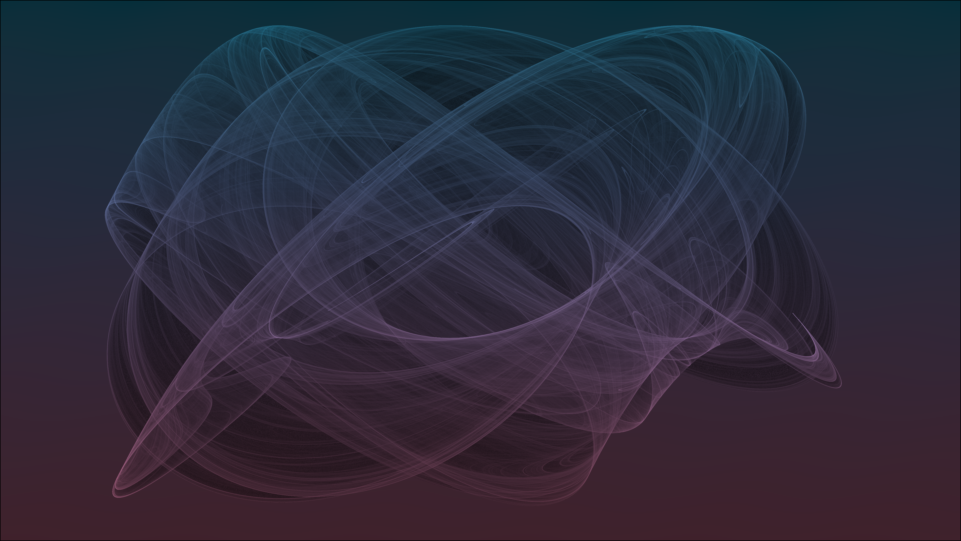

In [21]:
GAMMA = fill(0.21, Y, X)
N_MAX = fill(MAX, Y, X)
base = ones(Y, X)*0.25
image = map(color_map_background, grid[1:Y,1:X], N_MAX, GAMMA, rgb, base)

In [22]:
save("bureaublad.png", image)